# MRI Data Processing and Analysis

This notebook demonstrates how to set up and use the `DataPipe` class for handling neuroimaging data, from reading subject files to registering images to a common atlas and analyzing volumetric changes.

This notebook is for presentation only, and will not run the code

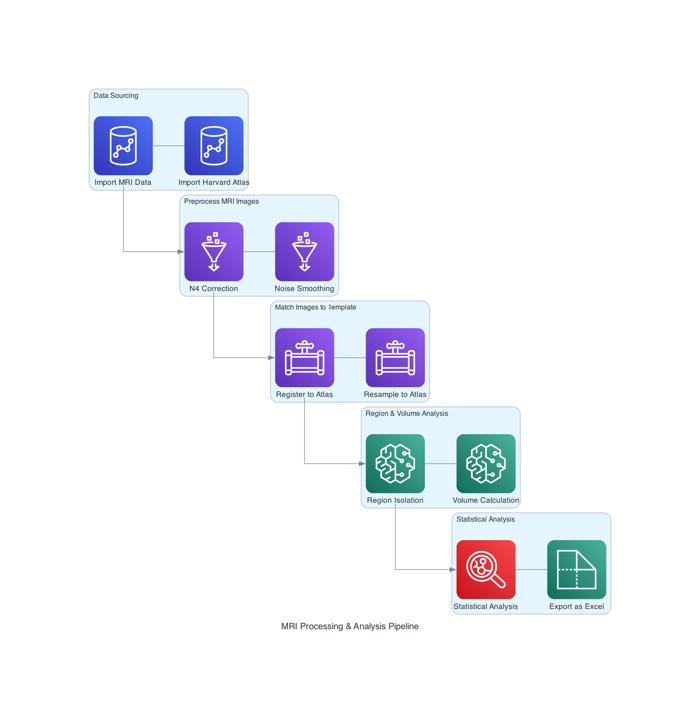

In [8]:
from IPython.display import display
from PIL import Image
img = Image.open("mri_processing_&_analysis_pipeline.png")
# Scale down while keeping aspect ratio
max_width = 700  # Set your desired width
aspect_ratio = img.height / img.width
new_height = int(max_width * aspect_ratio)

img_resized = img.resize((max_width, new_height))
display(img_resized)

## 1. Imports

We start by importing all necessary libraries, including `pandas` and `nibabel` for data handling, `ANTS` for image registration, and `matplotlib`/`nilearn` for plotting.

In [33]:
import os
import ants
import logging
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.plotting import plot_anat, plot_img
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.image import math_img, resample_to_img, get_data, load_img

## 2. The `DataPipe` Class

Below is the definition of the `DataPipe` class. It is designed to:

- Store and manage file paths and participant information.
- Load and process neuroimaging data.
- Perform image registration to a common atlas.
- Compute volumetric changes and differences across brain regions.

In [34]:
class DataPipe:
    """
    Responsibilities:
        • Handles subject MRI data.
        • Manages file paths and participant info.
        • Loads and processes neuroimaging data.
        • Performs registration to a common atlas.
    """
    pass

## 2.1: The `__init__` Method
This sets up paths, loads participants, fetches the atlas, etc.

In [35]:
def data_pipe_init(self, data_dir='Data', participants_tsv='Data/participants.tsv'):
        """
        Constructor for the Data class.
        data_dir : str
            The root directory containing subject data.
        participants_tsv : str
            Path to the participants.tsv file.

        Key Initialization Steps:
        •	Sets the working directory.
        •	Stores paths for data and participant information.
        •	Loads a participant DataFrame from a .tsv file.
        •	Fetches the Harvard-Oxford Atlas for regional brain analysis.
        •	Prepares additional DataFrame columns to store file paths and volumetric data.
        """
        # Sets the working directory to be where the file is found
        script_dir = os.path.dirname(os.path.abspath(__file__))
        os.chdir(script_dir)
        self.data_dir = os.path.abspath(data_dir)
        self.participants_tsv = os.path.abspath(participants_tsv)

        self.data_dir = data_dir
        self.participants_tsv = participants_tsv
        # Load participants DataFrame
        self.participants_df = pd.read_csv(self.participants_tsv, sep="\t")
        # Fetch atlas upon initialization
        self.fetch_harvard_oxford_atlas()
        # Prepare columns in participants_df for file paths and volumetric data
        self.prepare_dataframe_columns()

# Monkey-patch the __init__ method into DataPipe
DataPipe.__init__ = data_pipe_init

## 2.2: `fetch_harvard_oxford_atlas`
Loads atlas image, region labels, etc.

In [36]:
def fetch_harvard_oxford_atlas(self):
        """
        Purpose:
        •	Fetches the Harvard-Oxford cortical atlas.
        •	Loads atlas image and extracts region labels.
        •	Converts atlas data into a NumPy array.
        •	Handles exceptions in case the atlas cannot be retrieved.

        Key Variables:
        •	ATLAS_MAPS: The atlas image.
        •	ATLAS_IMAGE: Loaded version of ATLAS_MAPS.
        •	ATLAS_DATA: NumPy representation of the atlas.
        •	LABEL_NAMES: Names of brain regions.
        •	REGION_LABELS: Unique region indices.
        """
        # Fetch the Harvard-Oxford atlas
        try:
            ATLAS = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
            # Load the atlas image
            self.ATLAS_MAPS = ATLAS.maps
            self.ATLAS_IMAGE = load_img(self.ATLAS_MAPS)
            self.ATLAS_DATA = get_data(self.ATLAS_IMAGE)
            # Extract region names from the atlas
            self.LABEL_NAMES = ATLAS['labels']
            # Extract unique region labels from the atlas
            self.REGION_LABELS = np.unique(self.ATLAS_DATA)
        except Exception as e:
            logging.error(f"Error fetching/loading Harvard-Oxford atlas: {e}")
            raise  # In many cases, you'd want to stop execution if the atlas isn't available.

DataPipe.fetch_harvard_oxford_atlas = fetch_harvard_oxford_atlas

## 2.3: `prepare_dataframe_columns`
Adds new columns for file paths and volumetric data per region.

In [37]:
def prepare_dataframe_columns(self):
        """
        Purpose:
        •	Adds new columns to the participant DataFrame:
        •	File paths for MRI images.
        •	Volume calculations per brain region.
        •	Changes in volume between baseline and follow-up scans.

        Logic:
        •	Creates empty placeholders for each region’s volumetric data.
        •	Uses self.LABEL_NAMES to track which regions to include.
        •	Skips “Background” and “Unknown Region” labels.
        """
        # Prepare the new columns for file paths
        file_cols = ['Baseline File Path', 'Followup File Path']
        new_cols = {col: [None] * len(self.participants_df) for col in file_cols}
        
        # Prepare columns for volume and difference metrics for each region
        for label in self.LABEL_NAMES:
            # Skip background or unknown labels
            if label in ("Background", "Unknown Region"):
                continue
            new_cols[f"{label} Volume Avg"] = [None]*len(self.participants_df)
            new_cols[f"{label} Volume Change"] = [None]*len(self.participants_df)
            new_cols[f"{label} Change"] = [None]*len(self.participants_df)

        # Create an empty DataFrame and horizontally concatenate
        columns_df = pd.DataFrame(new_cols, index=self.participants_df.index)
        self.participants_df = pd.concat([self.participants_df, columns_df], axis=1)

DataPipe.prepare_dataframe_columns = prepare_dataframe_columns

## 2.4: `get_subject_file_pairs`
Locates subject baseline and follow-up files, stores paths in the DataFrame.

In [38]:
def get_subject_file_pairs(self):
        """
        Given a DataFrame of participants and the data directory,
        locate subject baseline (BL) and follow-up (FU) files
        and store them in the DataFrame columns.

        Purpose:
        •	Iterates through the data_dir to find subjects.
        •	Searches for baseline (BL) and follow-up (FU) files.
        •	Stores file paths in self.participants_df.
        """
        # Iterate through the data directory
        for subject_folder in os.listdir(self.data_dir):
            subject_path = os.path.join(self.data_dir, subject_folder)
            
            # Skip non-directories or irrelevant files
            if (
                not os.path.isdir(subject_path) 
                or subject_folder.startswith('.') 
                or subject_folder == 'derivatives'
            ):
                continue

        # Now match participants to BL/FU files
        for index, row in self.participants_df.iterrows():
            subject = row['participant_id']
            subject_path = os.path.join(self.data_dir, f"sub-{subject:03d}")
            
            # Define expected file paths for baseline and follow-up MRI scans
            baseline_file = os.path.join(
                subject_path, 
                'ses-BL', 
                'anat', 
                f"sub-{subject:03d}_ses-BL_T1w.nii.gz"
            )
            followup_file = os.path.join(
                subject_path, 
                'ses-FU', 
                'anat', 
                f"sub-{subject:03d}_ses-FU_T1w.nii.gz"
            )

            # Ensure both files exist before adding them to the DataFrame
            if os.path.exists(baseline_file) and os.path.exists(followup_file):
                # Add the file paths to the DataFrame
                self.participants_df.at[index, 'Baseline File Path'] = (
                    'Data/' + os.path.relpath(baseline_file, self.data_dir)
                )
                self.participants_df.at[index, 'Followup File Path'] = (
                    'Data/' + os.path.relpath(followup_file, self.data_dir)
                )
            else:
                print(f"Skipping subject {subject}: missing files.")

DataPipe.get_subject_file_pairs = get_subject_file_pairs

## 2.5: `register_and_convert_to_nifti`
Registers a subject’s MRI scan to a reference atlas using ANTs.

In [39]:
def register_and_convert_to_nifti(self, fixed_image, moving_image, subject_id, session, transform_type='Affine'):
        """
        Registers `moving_image` to `fixed_image` using ANTs, writes out the
        transformed result to disk as a NIfTI file, and returns the nibabel image.

        Purpose:
        •	Uses ANTs to register a subject’s MRI scan to a reference (atlas).
        •	Saves the registered image as a NIfTI file.
        •	Handles errors and skips re-registration if output already exists.

        Logic:
        1.	Check if the output file exists.
        2.	Apply bias field correction and smoothing.
        3.	Perform image registration using ANTs.
        4.	Save the registered image to disk.
        5.	Return a nibabel-compatible image.
        """
        out_path = f"output/registered_output_sub-{subject_id}_ses-{session}.nii.gz"
        
        # If the file already exists, load it and skip registration
        if os.path.exists(out_path):
            try:
                file = nib.load(out_path)
                return file
            except Exception as e:
                logging.error(f"Error loading existing registered image for subject {subject_id}, session {session}: {e}")
                raise
        
        # Preprocess the moving image (bias field correction + smoothing)
        moving_image = ants.n4_bias_field_correction(moving_image)
        moving_image = ants.smooth_image(moving_image, 2)

        # Registration
        try:
            outputImage = ants.registration(
                fixed=fixed_image,
                moving=moving_image,
                type_of_transform=transform_type
            )['warpedmovout']
        except Exception as e:
            logging.error(f"Error registering images for subject {subject_id}, session {session}: {e}")
            raise

        # Write out the registered result
        ants.image_write(outputImage, out_path)
        
        # Load the resulting file as a nibabel image
        try:
            file = nib.load(out_path)
            return file
        except Exception as e:
            logging.error(f"Error loading registered image from disk for subject {subject_id}, session {session}: {e}")
            raise

DataPipe.register_and_convert_to_nifti = register_and_convert_to_nifti

## 2.6: `loadImage`
Reads an image from disk, registers it to the Harvard-Oxford atlas, and resamples.

In [40]:
def loadImage(self, imgPath, subject_id, session):
        """
        Reads an image from a given path, then registers it against the
        Harvard-Oxford atlas, returning a NIfTI image resampled to the atlas space.
        
        Key Steps:
        1.	Load the Harvard-Oxford Atlas.
        2.	Read the subject’s MRI image.
        3.	Register the image to the atlas space.
        4.	Resample to match the atlas resolution.
        """
        # Path to your local Harvard-Oxford atlas file if needed:
        # (Should match what's inside your `fetch_atlas_harvard_oxford` location)
        atlasPath = '/Users/mayerunterberg/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz'
        atlas_image = ants.image_read(atlasPath)
        ants_img = ants.image_read(imgPath)
        
        # Register and convert to NIfTI
        nifti = self.register_and_convert_to_nifti(
            fixed_image=atlas_image,
            moving_image=ants_img,
            subject_id=subject_id,
            session=session
        )

        # Resample the result to the official atlas image just in case
        # (the loaded self.ATLAS_IMAGE might be the same, but we do this 
        #  to ensure consistent shape/resolution)
        img_resampled = resample_to_img(
            source_img=nifti,
            target_img=self.ATLAS_IMAGE,
            force_resample=True,
            copy_header=True,
            interpolation='nearest'
        )
        return img_resampled

DataPipe.loadImage = loadImage

## 2.7: `findDifferingAreasAndVolume`
Computes a difference map and calculates mean difference/volume changes per region.

In [41]:
def findDifferingAreasAndVolume(self, index, img1, img2, threshold=None):
        """
        Given two images, computes the difference map, calculates mean difference
        and volume changes per region, and records those metrics in the DataFrame.

        •	Computes difference maps between baseline and follow-up MRI images.
        •	Calculates mean intensity differences in brain regions.
        •	Estimates volume changes per region.
        •	Stores results in self.participants_df.
        """
        diff = math_img("img1 - img2", img1=img1, img2=img2)
        diff_data = get_data(diff)
        
        # For volume calculations, get data for each image
        img1_data = get_data(img1)
        img2_data = get_data(img2)
        
        # Use the ATLAS_IMAGE affine to find voxel volume
        voxel_sizes = np.abs(np.diag(self.ATLAS_IMAGE.affine)[:3])  # shape (3,)
        voxel_volume = np.prod(voxel_sizes)  # in mm^3

        for label in self.REGION_LABELS:
            # region_name from self.LABEL_NAMES
            if 0 <= label < len(self.LABEL_NAMES):
                region_name = self.LABEL_NAMES[label]
            else:
                region_name = "Unknown Region"
                continue
            
            if region_name in ("Background", "Unknown Region"):
                continue

            regionMask = (self.ATLAS_DATA == label)
            
            # Mean difference in region
            regionChanges = diff_data[regionMask]
            region_mean_diff = round(float(np.mean(regionChanges)), 2)
            
            # Volume difference (count of non-zero or above-threshold voxels)
            if threshold is not None:
                img1_masked = ((img1_data > threshold) & regionMask)
                img2_masked = ((img2_data > threshold) & regionMask)
            else:
                img1_masked = ((img1_data != 0) & regionMask)
                img2_masked = ((img2_data != 0) & regionMask)
            
            # Filters our zero voxels
            region_img1_voxels = np.count_nonzero(img1_masked)
            region_img2_voxels = np.count_nonzero(img2_masked)
            
            # Calculates region volume
            region_img1_volume = region_img1_voxels * voxel_volume
            region_img2_volume = region_img2_voxels * voxel_volume
            region_volume_diff = round(region_img1_volume - region_img2_volume, 2)
            avgVolume = round((region_img1_volume + region_img2_volume) / 2, 2)
            
            # Save to the DataFrame
            self.participants_df.loc[index, f"{region_name} Change"] = region_mean_diff
            self.participants_df.loc[index, f"{region_name} Volume Avg"] = avgVolume
            self.participants_df.loc[index, f"{region_name} Volume Change"] = region_volume_diff

DataPipe.findDifferingAreasAndVolume = findDifferingAreasAndVolume

## 2.8: `process_all_subjects`
Main loop to load and register images, compute differences, update DataFrame.

In [42]:
def process_all_subjects(self):
        """
        Main loop to process each subject in the participants DataFrame:
        1. Iterates through the participant DataFrame.
        2. Load baseline and follow-up files.
        3. Register them to the atlas space.
        4. Compute differences in each region and update participants_df.
        """
        # Loads base files
        for idx, row in self.participants_df.iterrows():
            baseLinePath = row['Baseline File Path']
            followUpPath = row['Followup File Path']
            if pd.isna(baseLinePath) or pd.isna(followUpPath):
                continue  # skip if missing file
            
            # Registers files
            subject_id = row['participant_id']
            baseLine = self.loadImage(baseLinePath, subject_id, 'BL')
            followUp = self.loadImage(followUpPath, subject_id, 'FU')
            
            # Computes differences
            self.findDifferingAreasAndVolume(idx, baseLine, followUp)

DataPipe.process_all_subjects = process_all_subjects

## 2.9: `display_brain_and_difference`
Displays baseline, follow-up, and a difference map side by side.

In [43]:
def display_brain_and_difference(self,
                                    baseline_file,
                                    followup_file,
                                    subject_id,
                                    show_glass_brain=True,
                                    show_spider_chart=True):
        """
        Displays multiple types of visualizations for baseline vs. follow-up MRI:
        1) Baseline & follow-up anatomical slices
        2) Simple difference map
        4) Glass brain (3D transparent) view of the difference
        6) (Optional) Spider chart of ROI-level changes
        7) (Optional) Correlation heatmap of ROI-level changes
        
        Parameters
        ----------
        baseline_file : str
            Path to the baseline MRI NIfTI file.
        followup_file : str
            Path to the follow-up MRI NIfTI file.
        show_glass_brain : bool
            If True, shows a glass brain visualization.
        show_spider_chart : bool
            If True, attempts to plot a spider chart of ROI-level changes (requires region data).
        show_correlation_heatmap : bool
            If True, plots a correlation heatmap of ROI changes (requires ROI data).
        """
        print("Loading images...")
        baseline_img = nib.load(baseline_file)
        followup_img = nib.load(followup_file)

        baseline_data = baseline_img.get_fdata()
        followup_data = followup_img.get_fdata()

        # Compute the raw difference: followup - baseline
        diff_data = followup_data - baseline_data
        diff_img = nib.Nifti1Image(diff_data, affine=baseline_img.affine)

        ############################################
        # 1) Show Baseline & Follow-Up MRIs
        ############################################
        print("Showing baseline and follow-up images...")
        plot_anat(baseline_img, title="Baseline MRI")
        plot_anat(followup_img, title="Follow-Up MRI")
        plt.show()

        ############################################
        # 2) Show Simple Difference Map
        ############################################
        print("Showing simple difference map (coolwarm)...")
        plot_img(diff_img, title="Difference MRI (Follow-Up - Baseline)",
                cmap='coolwarm', colorbar=True)
        plt.show()

        ############################################
        # 4) Optional: Glass Brain
        ############################################
        if show_glass_brain:
            print("Showing glass brain visualization...")
            plot_glass_brain(diff_img,
                            display_mode='lyrz',  # left, y, right, z
                            threshold=0.1,
                            cmap='coolwarm',
                            title='Glass Brain (difference)')
            plt.show()

        ############################################
        # 6) (Optional) Spider/Radar Chart of ROI Changes
        ############################################
        if show_spider_chart:
            print("Attempting to create a spider chart of ROI-level changes...")
            # We assume you have a dictionary or DataFrame with ROI-level changes
            # For instance: self.roi_differences = { 'ROIName': difference_value, ... }
            # This is an example with made-up data:
            example_roi_diffs = self.get_roi_differences_for_subject(subject_id)
            # Convert to sorted lists
            rois = list(example_roi_diffs.keys())
            diffs = list(example_roi_diffs.values())

            # We make a "circular" arrangement for spider chart
            # One trick is to repeat the first entry at the end
            rois.append(rois[0])
            diffs.append(diffs[0])

            # Angles
            angles = np.linspace(0, 2 * np.pi, len(rois), endpoint=False)

            fig, ax = plt.subplots(subplot_kw={'polar': True}, figsize=(6,6))
            ax.plot(angles, diffs, 'o-', linewidth=2)
            ax.fill(angles, diffs, alpha=0.25)
            ax.set_thetagrids(angles[:-1] * 180 / np.pi, rois[:-1])
            ax.set_title("Spider Chart of ROI Changes")
            plt.show()

DataPipe.display_brain_and_difference = display_brain_and_difference

## 2.10: `display_before_registry`
Displays baseline and follow-up images before registration.

In [44]:
def display_before_registry(self, baseline_file, followup_file):
        """
        Displays the brain images for baseline, follow-up, and their difference.
        """
        baseline_img = nib.load(baseline_file)
        followup_img = nib.load(followup_file)

        # Plot the follow-up and baseline images
        plot_img(followup_img, title="Follow-Up MRI Before Registry")
        plot_img(baseline_img, title="Baseline MRI Before Registry")
        plt.show()

DataPipe.display_before_registry = display_before_registry

## 4. Conclusion

In this notebook, we've outlined how to organize and process neuroimaging data using the `DataPipe` class. The workflow includes:

1. **Setting up** file paths and participant metadata.
2. **Fetching** and loading the Harvard-Oxford atlas.
3. **Registering** subject images to the atlas using ANTs.
4. **Computing** volumetric changes and differences in intensity.
5. **Visualizing** the results.

Feel free to add, remove, or modify the Markdown sections to suit your presentation style.